In [1]:
import pandas as pd

### **PREPROCESSING**

In [2]:
#Unsere Trainingsdaten einlesen
#Dieser Schritt wird einmalig passieren und dabei gehts um die Daten auf von denen wir dann unsere prediction basieren
#Da wir die Daten haben ist eigentlich egal ob die pickle oder csv sind deswegen nehm ich jetzt mal pickle
df = pd.read_pickle("Tank.pkl")
df.timestamp = pd.to_datetime(df.timestamp)
df_new = df.loc[df["CuStepNo ValueY"] != 2] #hat er uns ja gesagt diesen Schritt zu ignorieren
df_new["Next_Step"] = df_new["CuStepNo ValueY"].shift()
df_steps = df_new.loc[df_new["CuStepNo ValueY"] != df_new["Next_Step"]]
#df_steps ist nen Hilfsdataframe um später die nötigen nummer von Batches auf die Originaldaten zu bekommen
times = df_steps[df_steps["CuStepNo ValueY"] == 1].timestamp.to_list()
df_train = pd.DataFrame(columns=df_new.columns)
#df_test2 wird unser hilfsframe wo dann die batch nummer steht
for i in range(times.__len__()-1):
    df_test1 = df_new.loc[(df_new.timestamp >=times[i])&(df_new.timestamp <times[i+1])]
    df_test1["Batch"] = i
    df_train = pd.concat([df_train,df_test1])

/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_41137/1895370859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Next_Step"] = df_new["CuStepNo ValueY"].shift()
/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_41137/1895370859.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1["Batch"] = i
/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_41137/1895370859.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [4]:
#df_train["timestamp"] = pd.to_datetime(df_train["timestamp"])

In [3]:
df_train = df_train.fillna(0)

In [4]:
df_train_sample = df_train.sample(frac= 0.5)

### **PCA**

In [5]:
df_train_slice = df_train_sample.drop(["timestamp", "DeviationID ValueY"], axis= 1)

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [7]:
pc = PCA()
pc.fit(df_train_slice)

PCA()

In [8]:
df_pca = pd.DataFrame(pc.explained_variance_ratio_)

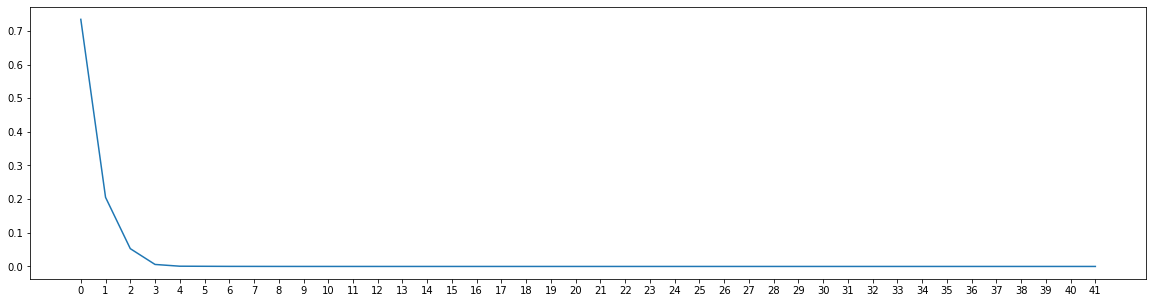

In [9]:
plt.figure(figsize= (20, 5))
plt.plot(df_pca)
plt.xticks(df_pca.index)
plt.show()

In [10]:
pc_train = PCA(n_components= 3).fit(df_train_slice)
df_train_1 = pc_train.transform(df_train_slice)

In [11]:
df_train_1

array([[-1721.29039362,  -264.9695125 ,    14.65280834],
       [  775.52548959,  -574.12238461,  -138.57385116],
       [  335.12877452,  -564.65709673,    15.71205501],
       ...,
       [  584.30546245,  -165.1017562 ,   303.02254467],
       [-1721.31252178,  -264.84526681,    14.53894357],
       [  208.23907391,   567.80850727,   398.48098623]])

### **TRAIN 1.0**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tslearn.early_classification import NonMyopicEarlyClassifier

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [78]:
#X1, X2, X3, y = df_train_1[:, 0], df_train_1[:, 1], df_train_1[:, 2], df_train["DeviationID ValueY"]

In [13]:
X = df_train_1
y = df_train_sample["DeviationID ValueY"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

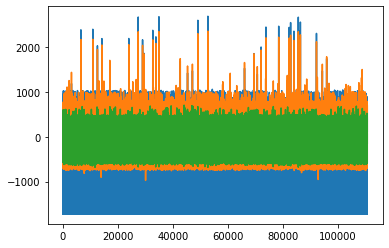

In [15]:
plt.plot(X_train)

In [19]:
X_train.shape

(110632, 3)

In [18]:
X_test

array([[-1722.19992156,  -265.73615594,    12.1020288 ],
       [  635.73308159,  -140.48702843,   221.58716151],
       [-1697.2800283 ,  -283.71018918,    82.18397155],
       ...,
       [  583.65888588,  -120.92961386,   285.34538436],
       [-1721.38818203,  -265.10949539,    14.39570362],
       [   15.23306828,   679.56000313,   -70.96923056]])

In [16]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


X_train1 = TimeSeriesScalerMeanVariance().fit_transform(X_train)

In [20]:
early_clf = NonMyopicEarlyClassifier(n_clusters= 3, cost_time_parameter= 1e-3, lamb= 1e2, random_state= 0).fit(X_train1, y_train)

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, early_clf.predict(X_train1))

0.5964368356352593

In [ ]:
X_test1 = TimeSeriesScalerMeanVariance().fit_transform(X_test)

### **TRAINING**

In [17]:
from tslearn.early_classification import NonMyopicEarlyClassifier
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [81]:
X = df_train.drop(["DeviationID ValueY", "timestamp"], axis= 1)
y = df_train["DeviationID ValueY"]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

In [70]:
#X_train, y_train = TimeSeriesScalerMeanVariance().fit_transform(X_train), TimeSeriesScalerMeanVariance().fit_transform(X_test) 

In [83]:
early_clf = NonMyopicEarlyClassifier(n_clusters= 3).fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 221264 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
